# Clustering analysis use-case with Synthetic FHIR and VCF Data
### Overview
**Important:** This walk-through assumes you have already used [our previous notebook](https://github.com/microsoft/genomicsnotebook/blob/main/sample-notebooks/fhir_long_read.ipynb)[<sup>[1]</sup>](#r1) to download FHIR data[<sup>[3]</sup>](#r3) in Parquet format[<sup>[4]</sup>](#r4).  
A Microsoft Healthcare and Life Sciences blog post accompanies the previous notebook, and can be found [here](https://techcommunity.microsoft.com/t5/healthcare-and-life-sciences/convert-synthetic-fhir-and-pacbio-vcf-data-to-parquet-and/ba-p/3577038)[<sup>[2]</sup>](#r2).

In **Section 1**, FHIR data stored in Parquet format is parsed into a pandas DataFrame[<sup>[5]</sup>](#r5) for further analysis.  
In **Section 2**, individual patient VCFs are merged into a single joint VCF. We are starting from the raw data again, rather than the Parquet data, in order to combine the VCFs in a different format (a joint VCF).  
In **Section 3**, the joint VCF is converted into a pandas DataFrame and missing values are imputed. Since our input is [VCF and not GVCF](https://github.com/broadinstitute/gatk-docs/blob/master/gatk3-faqs/What_is_a_GVCF_and_how_is_it_different_from_a_'regular'_VCF%3F.md)[<sup>[6]</sup>](#r6), absent variant calls are assumed to all be homozygous reference calls of average confidence. In future work, we plan to work with GVCF inputs.  
In **Section 4**, the two DataFrames are merged.  
In **Section 5**, we perform per-patient clustering analysis.

### Contents
[1. Extract FHIR Data: from .parquet to DataFrame](#1)  
[2. Merge individual VCFs into a joint VCF](#2)  
[3. Extract joint VCF: from .vcf to DataFrame](#3)  
[4. Data Merging and Normalization](#4)  
[5. Clustering Analysis](#5)  
[References](#references)

Note that we are providing an example architectural design to illustrate how Microsoft tools can be utilized to connect the pieces together (data + interoperability + secure cloud + AI tools), enabling researchers to conduct research analyzing genomics+clinical data. We are not providing or recommending specific instructions for how investigators should conduct their research with this notebook – we will leave that to the professionals!

## 1. Extract FHIR Data
### from `.parquet` to `DataFrame` <a id="1"></a>
First, we'll import the necessary libraries and set some useful variables.

In [1]:
# manage imports
import pandas as pd
from glob import glob
from datetime import datetime
import os, json, subprocess

# filepaths
fhir_dir = "*/fhir/result"
date = "2022/07/26"
pb_dir = "*/pacbio"

# globals
max_patients = 50
max_variants = 50

Next, we'll parse all the FHIR `Patient` data:

In [2]:
# parse patient information from each .parquet file
fhir_dfs = []
for patient_file in glob(f"{fhir_dir}/Patient/{date}/**/*.parquet"):
    
    # create dataframe for this .parquet file
    fhir_df = pd.DataFrame()
    orig_fhir_df = pd.read_parquet(patient_file)

    # set basic fields
    fhir_df["name"]    = [f"{' '.join(name[0]['prefix']) if name[0]['prefix'] else ''} {' '.join(name[0]['given'])} {name[0]['family']}" for name in orig_fhir_df["name"]]
    fhir_df["id"]      = orig_fhir_df["id"]
    fhir_df["city"]    = [addr[0]["city"]    for addr in orig_fhir_df["address"]]
    fhir_df["state"]   = [addr[0]["state"]   for addr in orig_fhir_df["address"]]
    fhir_df["country"] = [addr[0]["country"] for addr in orig_fhir_df["address"]]
    fhir_df["gender"]  = orig_fhir_df["gender"]
    fhir_df["married"] = [married["text"][0] for married in orig_fhir_df["maritalStatus"]]
    fhir_df["dead"]    = [dead is not None for dead in orig_fhir_df["deceased"]]
    fhir_df["twin+"]   = [mult["boolean"] if mult["boolean"] is not None else True for mult in orig_fhir_df["multipleBirth"]]
    
    # set age in years from birthDate
    ages = []
    for birthdate in orig_fhir_df["birthDate"]:
        year, month, day = map(int, birthdate.split("-"))
        ages.append((datetime.now()-datetime(year, month, day)).total_seconds() / (60*60*24*365.25))
    fhir_df["age"]     = ages

    # set "medical record number", from a host of other identifiers (social security, etc.)
    mrns = []
    for identifier_list in orig_fhir_df["identifier"]:
        for ident in identifier_list:
            if ident['type'] and json.loads(ident['type']['coding'])[0]['code'] == "MR":
                mrns.append(ident['value'])
    fhir_df["mrn"]     = mrns
    
# merge information
    fhir_dfs.append(fhir_df)
all_fhir_df = pd.concat(fhir_dfs).reset_index(drop=True)

For each patient, let's add their newest and oldest medication information based on their FHIR `MedicationRequest` history.

In [3]:
# parse medication information from each .parquet file
meds_dfs = []
for meds_file in glob(f"{fhir_dir}/MedicationRequest/{date}/**/*.parquet"):
    
    # create a dataframe for this .parquet file
    meds_df = pd.DataFrame()
    orig_meds_df = pd.read_parquet(meds_file)
    
    # add simple fields
    meds_df["id"] = orig_meds_df["id"]
    meds_df["code"] = ["None" if med["codeableConcept"] is None else med["codeableConcept"]["coding"][0]["code"] for med in orig_meds_df["medication"]]
    meds_df["type"] = ["None" if med["codeableConcept"] is None else med["codeableConcept"]["text"] for med in orig_meds_df["medication"]]
    meds_df["mrn"] = [subject["reference"].split(':')[2] for subject in orig_meds_df["subject"]] # urn:uuid:<mrn>
    
    # calculate years elapsed since medication was first requested
    elapsed = []
    for issued in orig_meds_df["authoredOn"]:
        year, month, day = map(int, issued.split("T")[0].split("-"))
        elapsed.append((datetime.now()-datetime(year, month, day)).total_seconds() / (60*60*24*365.25))
    meds_df["elapsed"] = elapsed

# merge information
    meds_dfs.append(meds_df)
all_meds_df = pd.concat(meds_dfs).reset_index(drop=True)
all_meds_df

# get newest meds
new_meds_df = all_meds_df.loc[all_meds_df.groupby('mrn')['elapsed'].agg('idxmin')]
new_codes, new_elapsed, new_types = [], [], []
for mrn in all_fhir_df['mrn']:
    try:
        new_codes.append(new_meds_df[new_meds_df['mrn'] == mrn].iloc[0]['code'])
        new_elapsed.append(new_meds_df[new_meds_df['mrn'] == mrn].iloc[0]['elapsed'])
        new_types.append(new_meds_df[new_meds_df['mrn'] == mrn].iloc[0]['type'])
    except IndexError:
        new_codes.append(0)
        new_elapsed.append(0)
        new_types.append("None")
all_fhir_df['newest_med_code'] = new_codes
all_fhir_df['newest_med_elapsed'] = new_elapsed
all_fhir_df['newest_med_type'] = new_types

# get oldest meds
old_meds_df = all_meds_df.loc[all_meds_df.groupby('mrn')['elapsed'].agg('idxmax')]
old_codes, old_elapsed, old_types = [], [], []
for mrn in all_fhir_df['mrn']:
    try:
        old_codes.append(old_meds_df[old_meds_df['mrn'] == mrn].iloc[0]['code'])
        old_elapsed.append(old_meds_df[old_meds_df['mrn'] == mrn].iloc[0]['elapsed'])
        old_types.append(old_meds_df[old_meds_df['mrn'] == mrn].iloc[0]['type'])
    except IndexError:
        old_codes.append(0)
        old_elapsed.append(0)
        old_types.append("None")
all_fhir_df['oldest_med_code'] = old_codes
all_fhir_df['oldest_med_elapsed'] = old_elapsed
all_fhir_df['oldest_med_type'] = old_types

We'll also add their newest and oldest diagnoses, from FHIRs `DiagnosticReport` resources.

In [4]:
# parse diagnosis report information from each .parquet file
reports_dfs = []
for reports_file in glob(f"{fhir_dir}/DiagnosticReport/{date}/**/*.parquet"):
    
    # create a dataframe for this .parquet file
    reports_df = pd.DataFrame()
    orig_reports_df = pd.read_parquet(reports_file)
    
    # add simple fields
    reports_df["id"]      = orig_reports_df["id"]
    reports_df["code"]    = [code["coding"][0]["code"] for code in orig_reports_df["code"]]
    reports_df["type"]    = [code["text"] for code in orig_reports_df["code"]]
    reports_df["mrn"]     = [subject["reference"].split(':')[2] for subject in orig_reports_df["subject"]] # urn:uuid:<mrn>
    
    # calculate years elapsed since report/diagnosis was issued
    elapsed = []
    for issued in orig_reports_df["issued"]:
        year, month, day = map(int, issued.split("T")[0].split("-"))
        elapsed.append((datetime.now()-datetime(year, month, day)).total_seconds() / (60*60*24*365.25))
    reports_df["elapsed"] = elapsed
    
# merge information
    reports_dfs.append(reports_df)
all_reports_df = pd.concat(reports_dfs).reset_index(drop=True)

# get newest reports
new_reports_df = all_reports_df.loc[all_reports_df.groupby('mrn')['elapsed'].agg('idxmin')]
new_reports_df.head(50)
new_codes = []
for mrn in all_fhir_df['mrn']:
    new_codes.append(new_reports_df[new_reports_df['mrn'] == mrn].iloc[0]['code'])
all_fhir_df['newest_report_code'] = new_codes
new_elapsed = []
for mrn in all_fhir_df['mrn']:
    new_elapsed.append(new_reports_df[new_reports_df['mrn'] == mrn].iloc[0]['elapsed'])
all_fhir_df['newest_report_elapsed'] = new_elapsed
new_types = []
for mrn in all_fhir_df['mrn']:
    new_types.append(new_reports_df[new_reports_df['mrn'] == mrn].iloc[0]['type'])
all_fhir_df['newest_report_type'] = new_types

# get oldest reports
old_reports_df = all_reports_df.loc[all_reports_df.groupby('mrn')['elapsed'].agg('idxmax')]
old_codes = []
for mrn in all_fhir_df['mrn']:
    old_codes.append(old_reports_df[old_reports_df['mrn'] == mrn].iloc[0]['code'])
all_fhir_df['oldest_report_code'] = old_codes
old_elapsed = []
for mrn in all_fhir_df['mrn']:
    old_elapsed.append(old_reports_df[old_reports_df['mrn'] == mrn].iloc[0]['elapsed'])
all_fhir_df['oldest_report_elapsed'] = old_elapsed
old_types = []
for mrn in all_fhir_df['mrn']:
    old_types.append(old_reports_df[old_reports_df['mrn'] == mrn].iloc[0]['type'])
all_fhir_df['oldest_report_type'] = old_types

Lastly, let's limit the dataset size to the specified maximum number of patients and preview the data.

In [5]:
all_fhir_df = all_fhir_df.drop(all_fhir_df.index[max_patients:])
all_fhir_df.head()

,name,id,city,state,country,gender,married,dead,twin+,age,...,newest_med_type,oldest_med_code,oldest_med_elapsed,oldest_med_type,newest_report_code,newest_report_elapsed,newest_report_type,oldest_report_code,oldest_report_elapsed,oldest_report_type
0,Mr. Carlos172 Benavides239,f8395477-be71-4542-b241-82d0813c3e1d,Saugus,MA,US,male,M,True,False,79.612951,...,Captopril 25 MG Oral Tablet,313782,39.845668,Acetaminophen 325 MG Oral Tablet,69409-1,30.742314,U.S. standard certificate of death - 2003 revi...,34117-2,75.169419,None
1,Jules135 Schmitt836,eeb892e6-8d4c-4977-a65e-6ec797ee4fa9,Boston,MA,US,male,N,False,False,0.417879,...,None,0,0.000000,None,34117-2,0.149570,None,34117-2,0.417879,None
2,Ms. Vonda514 Littel644,475922a6-ab70-45f4-bbaa-35384bf98fe9,Worcester,MA,US,female,N,False,False,19.079070,...,Ibuprofen 200 MG Oral Tablet,1870230,17.827872,NDA020800 0.3 ML Epinephrine 1 MG/ML Auto-Inje...,34117-2,0.105764,None,34117-2,17.855251,None
3,Ms. Marguerita493 Shields502,27127c03-4207-4ab9-9b39-2ee3be2ccb6a,Cambridge,MA,US,female,N,False,False,23.725202,...,Hydrochlorothiazide 25 MG Oral Tablet,757594,8.740945,Jolivette 28 Day Pack,34117-2,0.056483,None,34117-2,10.654703,None
4,Bonita405 Bayer639,a22fb1e0-45e1-4242-b6b5-a792a040e2f5,Chicopee,MA,US,female,N,False,False,1.633484,...,Amoxicillin 500 MG Oral Tablet,198405,1.222807,Ibuprofen 100 MG Oral Tablet,34117-2,0.196113,None,34117-2,1.633485,None


## 2. Merge individual VCFs into a joint VCF <a id="2"></a>
First, we need to install `bcftools` in order to process our VCF files. The `bcftools` documentation[<sup>[7]</sup>](#r7) can be found [here](https://samtools.github.io/bcftools/bcftools.html).  

`sudo apt-get install bcftools` is insufficient because the Ubuntu 18.04 package repository contains `bcftools-1.7`, which failed for us on this processing pipeline with an old bug. In the following cell, we install a more recent version, `bcftools-1.15`, from source.  

In [ ]:
%cd */code
!sudo apt-get -y install liblzma-dev libbz2-dev
!wget https://github.com/samtools/bcftools/releases/download/1.15.1/bcftools-1.15.1.tar.bz2
!tar -xf bcftools-1.15.1.tar.bz2
%cd bcftools-1.15.1
!sudo make install
!bcftools --version

We must also install `tabix`[<sup>[8]</sup>](#r8), a tool which indexes VCF files for faster processing.

In [ ]:
!sudo apt-get install -y tabix

We're first going to pre-process our VCF files by splitting up sites with multiple alleles into separate records, each with a single allele. For example,

CHROM  | POS  | REF  | ALT 
-------|------|------|----
chr20  | 1232 | A    | T,C

will become

CHROM  | POS  | REF  | ALT  
-------|------|------|----
chr20  | 1232 | A    | T  
chr20  | 1232 | A    | C

This ensures that the number of fields is static for each entry, particularly for the `PL` and `AF` columns.

In [ ]:
%%time
# skip VCFs which have already been split/pruned
orig_vcfs = set(glob(f"{pb_dir}/**/*.vcf.gz", recursive=True)) - \
            set(glob(f"{pb_dir}/**/*_split.vcf.gz", recursive=True)) - \
            set(glob(f"{pb_dir}/**/*_pruned.vcf.gz", recursive=True))

for vcf_fn in orig_vcfs:
    print(f"Splitting multi-alleles in '{vcf_fn}'")
    subprocess.run([
        "bcftools", "norm", 
        "--multiallelics", "-both",
        "--output-type", "z",
        "--output", f"{vcf_fn[:-7]}_split.vcf.gz", # remove .vcf.gz
        vcf_fn
    ])

Next, we perform LD (linkage disequilibrium) pruning[<sup>[9]</sup>](#r9) in order to remove variants with high covariance. Since we're only going to be looking at a small subset of each patient's variants, we want to make sure that the variants we do investigate are fairly independent.

In [ ]:
%%time
for vcf_fn in glob(f"{pb_dir}/**/*_split.vcf.gz", recursive=True):
    print(f"Pruning variants in '{vcf_fn}'")
    subprocess.run([
        "bcftools", "+prune", 
        "-m", "0.2",
        vcf_fn,
        "--output-type", "z",
        "--output", f"{vcf_fn[:-13]}_pruned.vcf.gz", # remove _split.vcf.gz
    ])

Index all individual VCFs.

In [ ]:
%%time 
for vcf_fn in glob(f"{pb_dir}/**/*_pruned.vcf.gz", recursive=True): # no gvcfs
    print(f"Indexing '{vcf_fn}'")
    subprocess.run(["tabix", "-f", "-p", "vcf", vcf_fn])

Merge VCF files into single joint VCF, and index it.

In [ ]:
%%time
subprocess.run(["bcftools", "merge"] + 
        ["-m", "none"] +
        list(glob(f"{pb_dir}/**/*_pruned.vcf.gz", recursive=True))[:max_patients] +
        ["-o", f"{pb_dir}_joint/{max_patients}_patients.vcf.gz"]
)
subprocess.run(["tabix", "-f", "-p", "vcf", f"{pb_dir}_joint/{max_patients}_patients.vcf.gz"])

## 3. Extract joint VCF <a id="3"></a>
### from `.vcf` to `DataFrame`

First, we'll use `bcftools query` to convert our VCF to a more general format that works well with existing data science libraries: TSV.

In [ ]:
%%time
# convert joint VCF to CSV
subprocess.run(["bcftools", "query", 
        "--print-header",
        "-f", "%CHROM\t%POS\t%TYPE\t%REF\t%ALT\t%QUAL\t%FILTER\t%INFO/DP\t%INFO/AF\t%INFO/AQ\t%INFO/AN\t%INFO/AC[\t%GT\t%AD\t%DP\t%GQ\t%PL]\n", 
        f"{pb_dir}_joint/{max_patients}_patients.vcf.gz",
        "-o", f"{pb_dir}_tsv/{max_patients}_patients.tsv"
])

Next, let's define a list of all patients, and functions for computing GT and PL.

In [6]:
# save list of patients
patients = [p.decode() for p in subprocess.run(
    ["bcftools", "query", 
         "--list-samples", f"{pb_dir}_joint/{max_patients}_patients.vcf.gz"], 
    stdout=subprocess.PIPE).stdout.splitlines()]

In [7]:
# replace unknown calls with ref-calls, and remove phasing info (1|0 -> 0/1)
def gt_type(gt_str):
    gt_str = gt_str.replace(".","0")
    if (gt_str[0] == '0' and gt_str[2] == '1') or (gt_str[0] == '1' and gt_str[2] == '0'): return '0/1'
    if gt_str[0] == '0' and gt_str[2] == '0': return '0/0'
    if gt_str[0] == '1' and gt_str[2] == '1': return '1/1'
    else: return '?/?'

In [8]:
# parse PL data if available; otherwise compute from other fields
def get_pl(gt, gq, pl, ac):
    if pl == '.': # missing, compute from GT/GQ
        if (ac == 0 and gt == '0/0') or (ac == 1 and gt == '0/1') or (ac == 2 and gt == '1/1'): # chosen allele
            return 0
        else: # not chosen allele
            return gq 
    else: # parse out of PL data
        return int(pl.split(',')[ac])

Afterwards, we load the TSV into a DataFrame, impute missing values, and perform filtering.

In [ ]:
%%time
# remove numbered prefix from column names (e.g. "[1]CHROM"->"CHROM")
vcf_df = pd.read_csv(f"{pb_dir}_tsv/{max_patients}_patients.tsv", delimiter="\t", nrows=100000)
vcf_df.columns = [col.split("]")[1] for col in vcf_df.columns]

# filter out variants which are too homogenous across patients (for more interesting analysis, don't use for real datasets)
# a real application may instead have a whitelist/mask of genomic regions or variants of interest
min_freq = 0.05
max_freq = 0.95
gt_is_empty = pd.concat([vcf_df[f'{p}:GT'] == './.' for p in patients], axis=1)
gt_is_ref = pd.concat([vcf_df[f'{p}:GT'] == '0/0' for p in patients], axis=1)
n_valid = max_patients - (gt_is_empty | gt_is_ref).sum(axis=1)
in_freq_range = [x/max_patients < max_freq and x/max_patients > min_freq for x in n_valid]
vcf_df = vcf_df[in_freq_range]
print(f'selected variants: {len(vcf_df)}')

# impute missing values using median for all numeric fields
number_cols = ["QUAL", "DP", "AQ"] + [f"{patient}:GQ" for patient in patients] + [f"{patient}:DP" for patient in patients]
print(f'Missing values in the following columns will be imputed using per-patient medians.\nThis is required because unlike GVCFs, VCFs do not contain depth and quality information for reference calls.')
for nc in number_cols:
    print(f'{nc} missing: {len(vcf_df[vcf_df[nc] == "."])}')
    median = pd.to_numeric(vcf_df.loc[vcf_df[nc] != ".", nc]).median()
    vcf_df.loc[vcf_df[nc]=='.', nc] = median
    vcf_df[nc] = pd.to_numeric(vcf_df[nc])

# compute phred likelihoods and allele frequencies for each sample
for p in patients:
    vcf_df[f'{p}:GT'] = vcf_df[f'{p}:GT'].map(gt_type)
    vcf_df[f'{p}:PL_0/0'] = vcf_df.apply(lambda row: get_pl(gt = row[f'{p}:GT'], gq = row[f'{p}:GQ'], pl = row[f'{p}:PL'], ac = 0), axis=1)
    vcf_df[f'{p}:PL_0/1'] = vcf_df.apply(lambda row: get_pl(gt = row[f'{p}:GT'], gq = row[f'{p}:GQ'], pl = row[f'{p}:PL'], ac = 1), axis=1)
    vcf_df[f'{p}:PL_1/1'] = vcf_df.apply(lambda row: get_pl(gt = row[f'{p}:GT'], gq = row[f'{p}:GQ'], pl = row[f'{p}:PL'], ac = 2), axis=1)
    
    vcf_df[f'{p}:AF_0'] = vcf_df.apply(lambda row: 1 if row[f'{p}:AD'] == '.' else int(row[f'{p}:AD'].split(",")[0]) / max(row[f'{p}:DP'], 1) , axis=1)
    vcf_df[f'{p}:AF_1'] = vcf_df.apply(lambda row: 0 if row[f'{p}:AD'] == '.' else int(row[f'{p}:AD'].split(",")[1]) / max(row[f'{p}:DP'], 1) , axis=1)

# filter by depth/quality, and remove complex variants
vcf_df = vcf_df[vcf_df['DP'] >= 15]
vcf_df = vcf_df[vcf_df['QUAL'] >= 20]
vcf_df = vcf_df[vcf_df['TYPE'] != 'OTHER']
print(f'passing variants: {len(vcf_df)}')

# limit to specified number of variants
vcf_df = vcf_df.drop(vcf_df.index[max_variants:])
vcf_df.reset_index(inplace=True)
print(f'selected variants: {len(vcf_df)}')
vcf_df.head()

Lastly, we'll transpose the dataframe so that each row corresponds to a single patient.

In [ ]:
%%time

# define the fields we'll be using in our final dataframe
fields = []
sample_fields = ["GT", "AF_0", "AF_1", "PL_0/0", "PL_0/1", "PL_1/1", "DP"]

# create empty dataframe
pb_df = pd.DataFrame(columns=[f"{var_id}:{fld}" for var_id in range(len(vcf_df)) for fld in fields + sample_fields], index=patients)

# fill dataframe
for idx, row in vcf_df.iterrows():
    for f in fields:
        for p in patients:
            pb_df.loc[p][f"{idx}:{f}"] = row[f]
    for f in sample_fields:
        for p in patients:
            pb_df.loc[p][f"{idx}:{f}"] = row[f"{p}:{f}"]

# new index
pb_df.reset_index(inplace=True)
pb_df = pb_df.rename(columns = {'index': 'patient_id'})
pb_df.head()

## 4. Data Merging and Normalization <a id="4"></a>

Since one row corresponds to a single patient in both our PacBio and FHIR datasets, we can easily append these two datasets side by side.  
Note that for real applications, each row's PacBio data must be matched up with the FHIR data for the corresponding patient. Since our FHIR data is synthetic, this matchup doesn't matter.

In [11]:
all_df = pd.concat([all_fhir_df, pb_df], axis=1)
all_df.head()

,name,id,city,state,country,gender,married,dead,twin+,age,...,48:PL_0/1,48:PL_1/1,48:DP,49:GT,49:AF_0,49:AF_1,49:PL_0/0,49:PL_0/1,49:PL_1/1,49:DP
0,Mr. Carlos172 Benavides239,f8395477-be71-4542-b241-82d0813c3e1d,Saugus,MA,US,male,M,True,False,79.612951,...,8,8,7,0/0,1,0,0,8,8,7
1,Jules135 Schmitt836,eeb892e6-8d4c-4977-a65e-6ec797ee4fa9,Boston,MA,US,male,N,False,False,0.417879,...,3,3,7,0/0,1,0,0,3,3,7
2,Ms. Vonda514 Littel644,475922a6-ab70-45f4-bbaa-35384bf98fe9,Worcester,MA,US,female,N,False,False,19.079070,...,0,0,5,0/1,0.285714,0.714286,29,0,23,7
3,Ms. Marguerita493 Shields502,27127c03-4207-4ab9-9b39-2ee3be2ccb6a,Cambridge,MA,US,female,N,False,False,23.725202,...,4,4,5,0/0,1,0,0,4,4,5
4,Bonita405 Bayer639,a22fb1e0-45e1-4242-b6b5-a792a040e2f5,Chicopee,MA,US,female,N,False,False,1.633484,...,9,9,15,0/0,1,0,0,9,9,15


Once all this information is in a single table, we can select the most useful columns and convert/normalize data into a format which is best for ML applications. 

In [12]:
# for normalization
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

# select useful FHIR columns
ml_df = pd.DataFrame()
ml_df['alive'] = [1-int(x) for x in all_df['dead']]
ml_df['twin+'] = [int(x) for x in all_df['twin+']]
ml_df['male'] = [1 if g == 'male' else 0 for g in all_df['gender']]
ml_df['age'] = all_df['age']
ml_df = pd.merge(
    left = ml_df,
    right = pd.get_dummies(all_df['married']),
    left_index = True,
    right_index = True,
)
ml_df = ml_df.rename(columns={'M': 'married', 'N': 'never_married', 'S': 'single'})
ml_df['old_report_age'] = all_df['oldest_report_elapsed']
ml_df['new_report_age'] = all_df['newest_report_elapsed']
ml_df['old_med_age'] = all_df['oldest_med_elapsed']
ml_df['new_med_age'] = all_df['newest_med_elapsed']
new_med_code_df = pd.get_dummies(all_df['newest_med_code'])
ml_df = pd.merge(
    left = ml_df,
    right = new_med_code_df.add_prefix("new_med_code:"),
    left_index = True,
    right_index = True,
)

# add all variants (ignoring DP, AF, PL for now)
for var_idx in range(max_variants):
    gt_df = pd.get_dummies(all_df[f'{var_idx}:GT'])
    ml_df = pd.merge(
        left = ml_df,
        right = gt_df.add_prefix(f'{var_idx}:'),
        left_index = True,
        right_index = True,
    )

    #ml_df[f'{var_idx}:DP'] = all_df[f'{var_idx}:DP']
    
# normalize
age_cols = ['age', 'old_report_age', 'new_report_age', 'old_med_age', 'new_med_age'] #+ [f'{var_idx}:DP' for var_idx in range(max_variants)]
ml_df[age_cols] = mms.fit_transform(ml_df[age_cols])
ml_df.head()

,alive,twin+,male,age,married,never_married,single,old_report_age,new_report_age,old_med_age,...,46:0/1,46:1/1,47:0/0,47:0/1,47:1/1,48:0/0,48:0/1,48:1/1,49:0/0,49:0/1
0,0,0,1,0.944276,1,0,0,0.956858,1.000000,0.580042,...,0,0,1,0,0,1,0,0,1,0
1,1,0,1,0.000000,0,1,0,0.000000,0.003922,0.000000,...,0,0,1,0,0,1,0,0,1,0
2,1,0,0,0.222505,0,1,0,0.223207,0.002496,0.259524,...,0,0,1,0,0,0,1,0,0,1
3,1,0,0,0.277903,0,1,0,0.131037,0.000891,0.127244,...,0,0,1,0,0,1,0,0,1,0
4,1,0,0,0.014494,0,1,0,0.015560,0.005438,0.017801,...,0,0,1,0,0,1,0,0,1,0


## 5. Clustering Analysis <a id="5"></a>

Before we can perform clustering, we must select a reasonable number of clusters for grouping patients. The k-means++ and spectral clustering algorithms require a predetermined number of clusters as inputs. This can be done using the "elbow method", where we select the number of clusters after which there are diminishing returns (in terms of cluster inertia) of introducing additional clusters. This appears in a graph of (x = # clusters, y = total inertia) as a bend, or elbow. In our dataset, we find a slight elbow at `n_clusters = 4`.

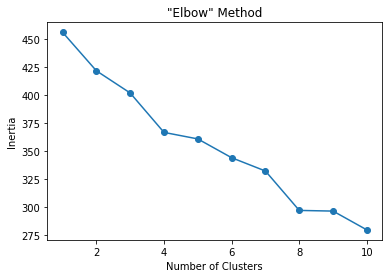

In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertias = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i).fit(ml_df)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('"Elbow" Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

Here, we demonstrate several clustering methods on our patient dataset.  
You can find more information about each clustering method at [`scikit-learn`'s Clustering Page](https://scikit-learn.org/stable/modules/clustering.html#clustering)[<sup>[10]</sup>](#r10).

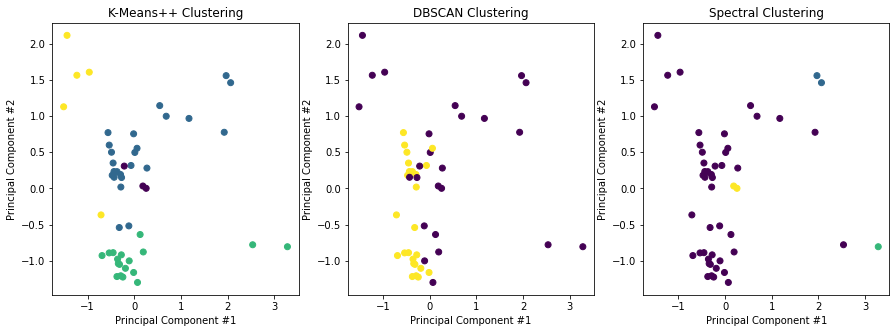

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering

# three clustering options
n_clusters = 4
cluster1 = KMeans(n_clusters=n_clusters, init='k-means++', n_init=5).fit(ml_df)
cluster2 = DBSCAN(eps=3, min_samples=3).fit(ml_df)
cluster3 = SpectralClustering(n_clusters=n_clusters).fit(ml_df)

# break down ML DF into top 2 principal components
pca2 = PCA(n_components = 2)
pc = pca2.fit_transform(ml_df)
pc_df = pd.DataFrame(data = pc, columns = ['pc1', 'pc2'])

# plot different clustering methods
fig, ax = plt.subplots(1,3, figsize=(15,5))
methods = ["K-Means++", "DBSCAN", "Spectral"]
clusters = [cluster1, cluster2, cluster3]
for x in range(3):
    ax[x].set_title(f"{methods[x]} Clustering")
    ax[x].set_xlabel('Principal Component #1')
    ax[x].set_ylabel('Principal Component #2')
    ax[x].scatter(pc_df['pc1'], pc_df['pc2'], c=clusters[x].labels_)
plt.show()

Next, let's evaluate the performance of these clustering methods. More information the metrics used can again be found at [`scikit-learn`'s Clustering Page](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)[<sup>[10]</sup>](#r10).

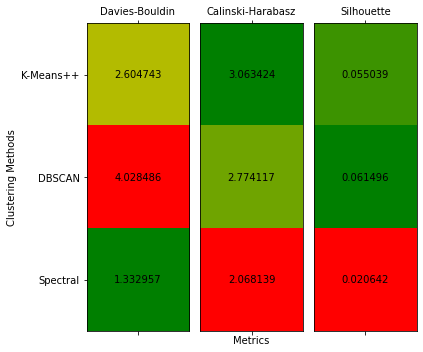

In [17]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from  matplotlib.colors import LinearSegmentedColormap
import numpy as np

# calculate evaluation metrics
metrics = ["Davies-Bouldin", "Calinski-Harabasz", "Silhouette"]
high_is_good = [False, True, True]
scores = np.zeros((3,3))
for x in range(3):
    scores[x,0] = davies_bouldin_score(ml_df, clusters[x].labels_)
    scores[x,1] = calinski_harabasz_score(ml_df, clusters[x].labels_)
    scores[x,2] = silhouette_score(ml_df, clusters[x].labels_, metric='euclidean')

# plot colormaps
fig, ax = plt.subplots(1,3, figsize=(6,5))
for x in range(3):
    cmap = LinearSegmentedColormap.from_list('rg',["r", "y", "g"], N=256) if high_is_good[x] else \
           LinearSegmentedColormap.from_list('gr',["g", "y", "r"], N=256)
    ax[x].matshow(np.expand_dims(scores[:,x], axis=1), cmap=cmap)
    ax[x].set_xticks([0])
    ax[x].set_xticklabels([metrics[x]])
    if x == 0:
        ax[x].set_yticklabels([0] + methods)
    else:
        ax[x].set_yticks([])
    for y in range(3):
        ax[x].text(0, y, f'{scores[y,x]:2f}', va='center', ha='center')

# display
ax[0].set_ylabel('Clustering Methods')
ax[1].set_xlabel('Metrics')
plt.tight_layout()
plt.show()

Lastly, here's an agglomerative clustering dendrogram, which can also be used to cluster patients:

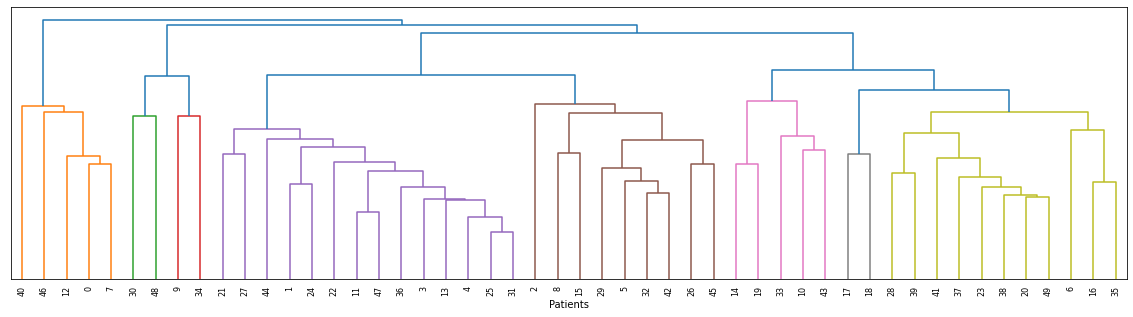

In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(20,5))
linkage_data = linkage(ml_df, method='ward', metric='euclidean')
dendrogram(linkage_data)
plt.xlabel('Patients')
plt.yticks([])
plt.show()

## References <a id="references"></a>
[1]  <a id="r1"></a> Previous Jupyter Notebook: https://github.com/microsoft/genomicsnotebook/blob/main/sample-notebooks/fhir_long_read.ipynb  
[2]  <a id="r2"></a> Microsoft Blog Post:https://techcommunity.microsoft.com/t5/healthcare-and-life-sciences/convert-synthetic-fhir-and-pacbio-vcf-data-to-parquet-and/ba-p/3577038  
[3]  <a id="r3"></a> FHIR HL7: http://hl7.org/fhir/index.html  
[4] <a id="r4"></a> Parquet File Format: https://spark.apache.org/docs/latest/sql-data-sources-parquet.html  
[5] <a id="r5"></a> Python `pandas` library: https://pandas.pydata.org/  
[6] <a id="r6"></a> Broad GATK GVCF Explanation: https://github.com/broadinstitute/gatk-docs/blob/master/gatk3-faqs/What_is_a_GVCF_and_how_is_it_different_from_a_'regular'_VCF%3F.md  
[7] <a id="r7"></a> `bcftools` Documentation: https://samtools.github.io/bcftools/bcftools.html  
[8] <a id="r8"></a> HTSlib/SAMtools/Tabix Homepage: https://www.htslib.org/  
[9] <a id="r9"></a> Linkage Disequilibrium: https://en.wikipedia.org/wiki/Linkage_disequilibrium  
[10] <a id="r10"></a> Scikit-Learn Clustering: https://scikit-learn.org/stable/modules/clustering.html#clustering

# NOTICES


THIS NOTEBOOK JUST PROVIDE A SAMPLE CODES FOR EDUCATIONAL PURPOSES. MICROSOFT DOES NOT CLAIM ANY OWNERSHIP ON THESE CODES AND LIBRARIES. MICROSOFT PROVIDES THIS NOTEBOOK AND SAMPLE USE OF  LIBRARIES ON AN “AS IS” BASIS. DATA OR ANY MATERIAL ON THIS NOTEBOOK. MICROSOFT MAKES NO WARRANTIES, EXPRESS OR IMPLIED, GUARANTEES OR CONDITIONS WITH RESPECT TO YOUR USE OF THIS NOTEBOOK. TO THE EXTENT PERMITTED UNDER YOUR LOCAL LAW, MICROSOFT DISCLAIMS ALL LIABILITY FOR ANY DAMAGES OR LOSSES, INCLUDING DIRECT, CONSEQUENTIAL, SPECIAL, INDIRECT, INCIDENTAL OR PUNITIVE, RESULTING FROM YOUR USE OF THIS NOTEBOOK.

#### Notebook prepared by [Tim Dunn](https://github.com/TimD1)- Research Intern- Microsoft Biomedical Platforms and Genomics